# Deep Learning Project - Cycle-Gan


### In this NoteBook exists the implementation and training of the Cycle-Gan Model over Monet paintings

The NoteBook consists of alot of parts:

###Part 1: Data
in this part we import the needed data (monet paitings and the normal photos) for the raining part, and also import all the important libraries for the training.

###Part 2: Paintings Selection.
as was asked in the projct we need to train the model only using 30 paintings so in this part we use the K-Means algorithm to choose the mose diversed 30 images for the training (more details in the section).

###Part 3: Defining The Generator.
as you know the Cycle-Gan Model usses 2 Generators in the training the one we need witch convert a normal photo to a monet painting, and another one to convert monet painting to a normal photo. 

###Part 4: Defining The Discriminator.
the Cycle-Gan Model usses 2 Discriminators in the training the one that deside if a given image is monet painting, and aother one that deside if an image is a normal image. 

###Part 5: Util Functions. 
here exists some important functions we may use later.

###Part 8: Training the Model:
here at the last part we show improve the last model more and it gave us the best results so we deside that this would be the Final Model.





### Big Thanks to Aladdin Persson for his Cycle-Gan paper walk throgh video: 
https://www.youtube.com/watch?v=5jziBapziYE&t=944s

# Import Data

In [ ]:
pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown 1CyA3wFFry-g6IkrA63mwqc5P_nCz26RV
!gdown 19qCyZhK-UYRYR0d5Y0HJBcs2tkCmyERD

import shutil
shutil.unpack_archive("monet_jpg.zip")
shutil.unpack_archive("photo_jpg.zip")

Downloading...
From: https://drive.google.com/uc?id=1CyA3wFFry-g6IkrA63mwqc5P_nCz26RV
To: /content/monet_jpg.zip
100% 4.93M/4.93M [00:00<00:00, 19.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=19qCyZhK-UYRYR0d5Y0HJBcs2tkCmyERD
To: /content/photo_jpg.zip
100% 98.1M/98.1M [00:05<00:00, 17.3MB/s]


In [ ]:
import os
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import random, torch, os, numpy as np
import torch.nn as nn
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

import matplotlib.pyplot  as plt

# Select best 30 Monet Paintings

To ensure that our model captures the essence of
Monet’s style, we approached this task with careful consideration and selected the subset using the k-means algorithm.

Using K-Means we parttition the Monet images into k clusters based on their visual similarity, we were able to select a representative subset of images that are diverse in their style and content while still capturing the overall characteristics of Monet’s artistic style

In [ ]:
import os
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Load images
image_paths = [os.path.join('monet_jpg', f) for f in os.listdir('monet_jpg')]
images = [io.imread(path) for path in image_paths]

# Flatten images
flattened_images = [image.ravel() for image in images]

# Shuffle images
X = np.array(shuffle(flattened_images))

# Apply k-means
kmeans = KMeans(n_clusters=30).fit(X)

# Get cluster labels
labels = kmeans.labels_

# Get 30 images corresponding to cluster centers
selected_images = [images[np.where(labels == i)[0][0]] for i in range(30)]

Create a folder called best_30 to save the best 30 Monet paintings

In [ ]:
os.mkdir("best_30")

for i, image in enumerate(selected_images):
    io.imsave(f'best_30/image_{i}.jpg', image)

shutil.make_archive("best_30", 'zip', "best_30")

'/content/best_30.zip'

Plot the 30 paintings.

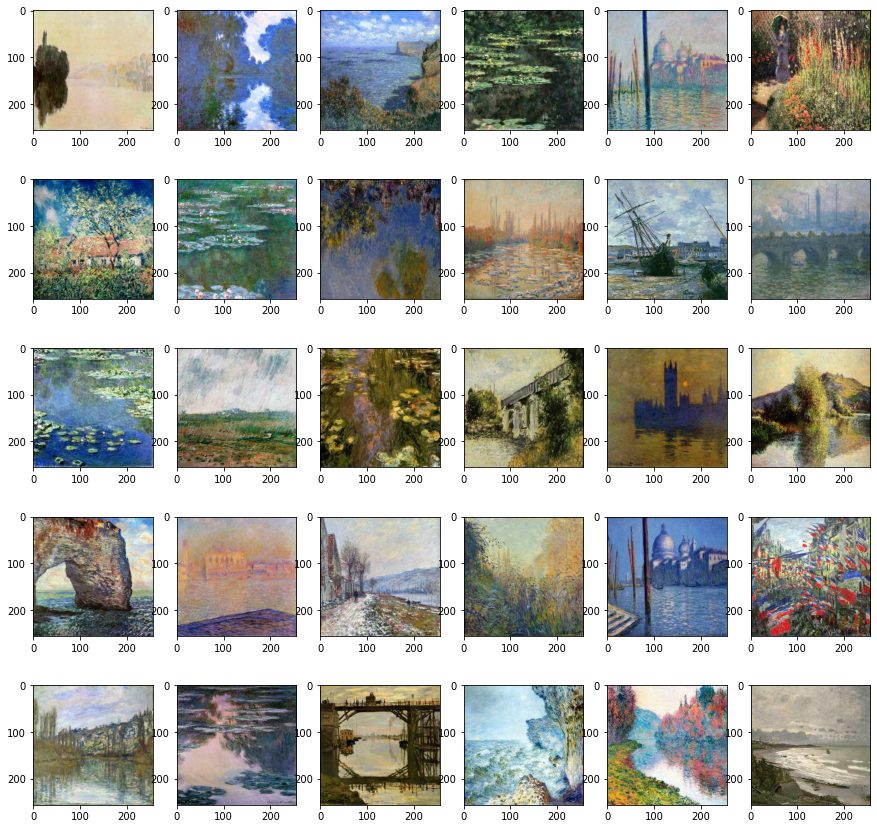

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(15, 15))

for i in range(30):
    r = i // 6
    c = i % 6
    axs[r, c].imshow(selected_images[i])
plt.show()

# Generator

The Generator is built in diffirent layers \\
First are 3 donwsampling Convilutional Blocks Followed be 6 ResidualBlock layers ending in 3 more upsampling convilutional blocks 

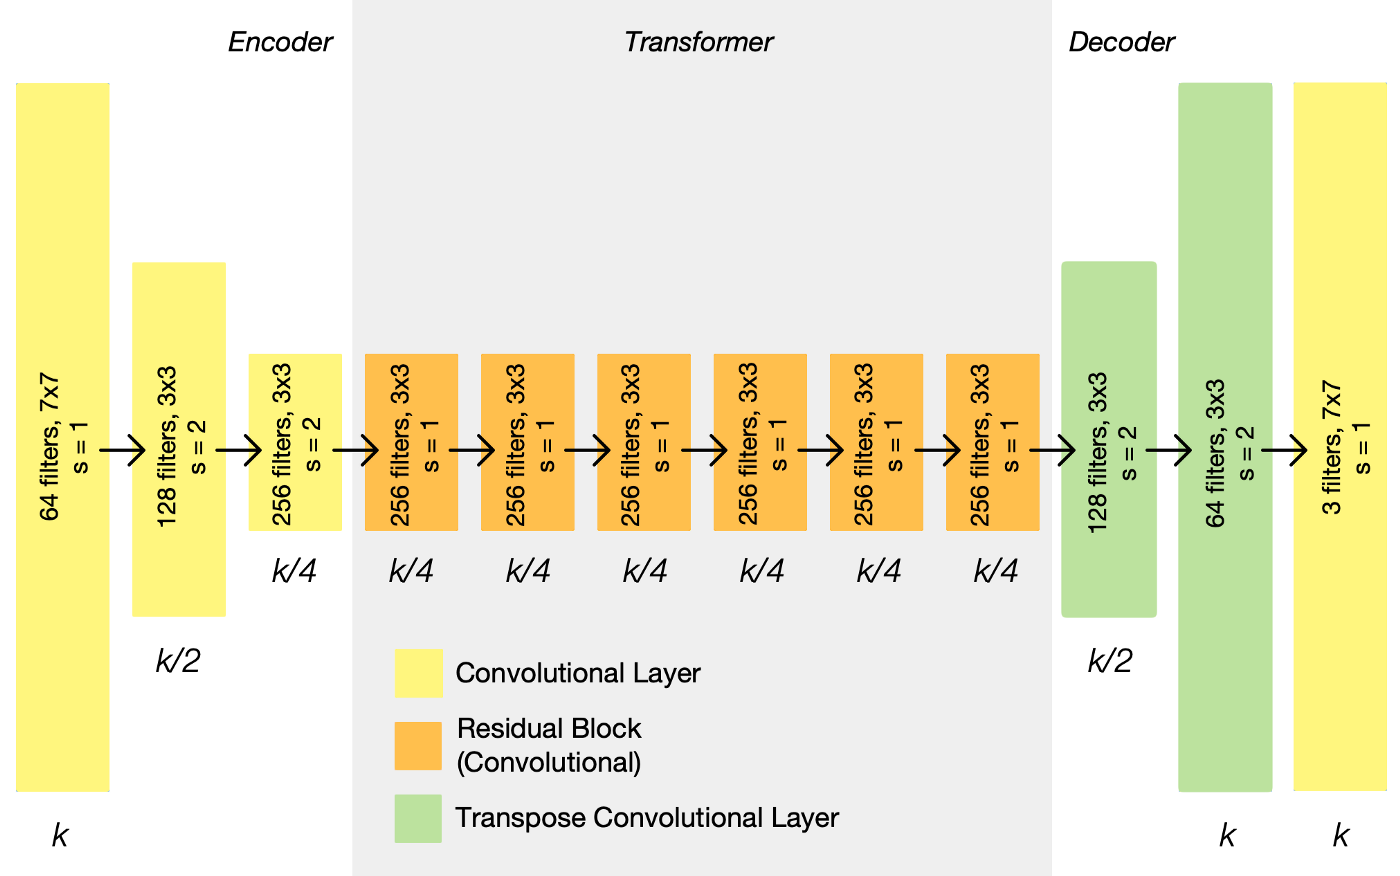

In [ ]:
#Define a convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        # define convolutional block with reflection padding, instance normalization, and ReLU activation
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

#Define a residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # define residual block with two convolutional blocks (with ReLU activation on the first block only)
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

#Define the generator network
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        # define initial convolutional block
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1,
                      padding=3, padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True), )
        # Define the downsampling convolutional blocks with stride=2
        self.down_blocks = nn.ModuleList([
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2,
                    padding=1
                ),
                ConvBlock(
                    num_features * 2, num_features * 4, kernel_size=3, stride=2,
                    padding=1,),
                ])
        # Define the residual blocks using the ResidualBlock class
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        # Define the upsampling convolutional blocks
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4, num_features * 2, down=False, kernel_size=3,
                    stride=2, padding=1, output_padding=1,
                ),
                ConvBlock(
                    num_features * 2, num_features * 1, down=False, kernel_size=3,
                    stride=2, padding=1, output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1, img_channels, kernel_size=7, stride=1,
            padding=3, padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

# Discriminator

The Discriminator uses a Pach-Gan by defining a 4 convilutional layers and activating the sigmoid function on the last layer

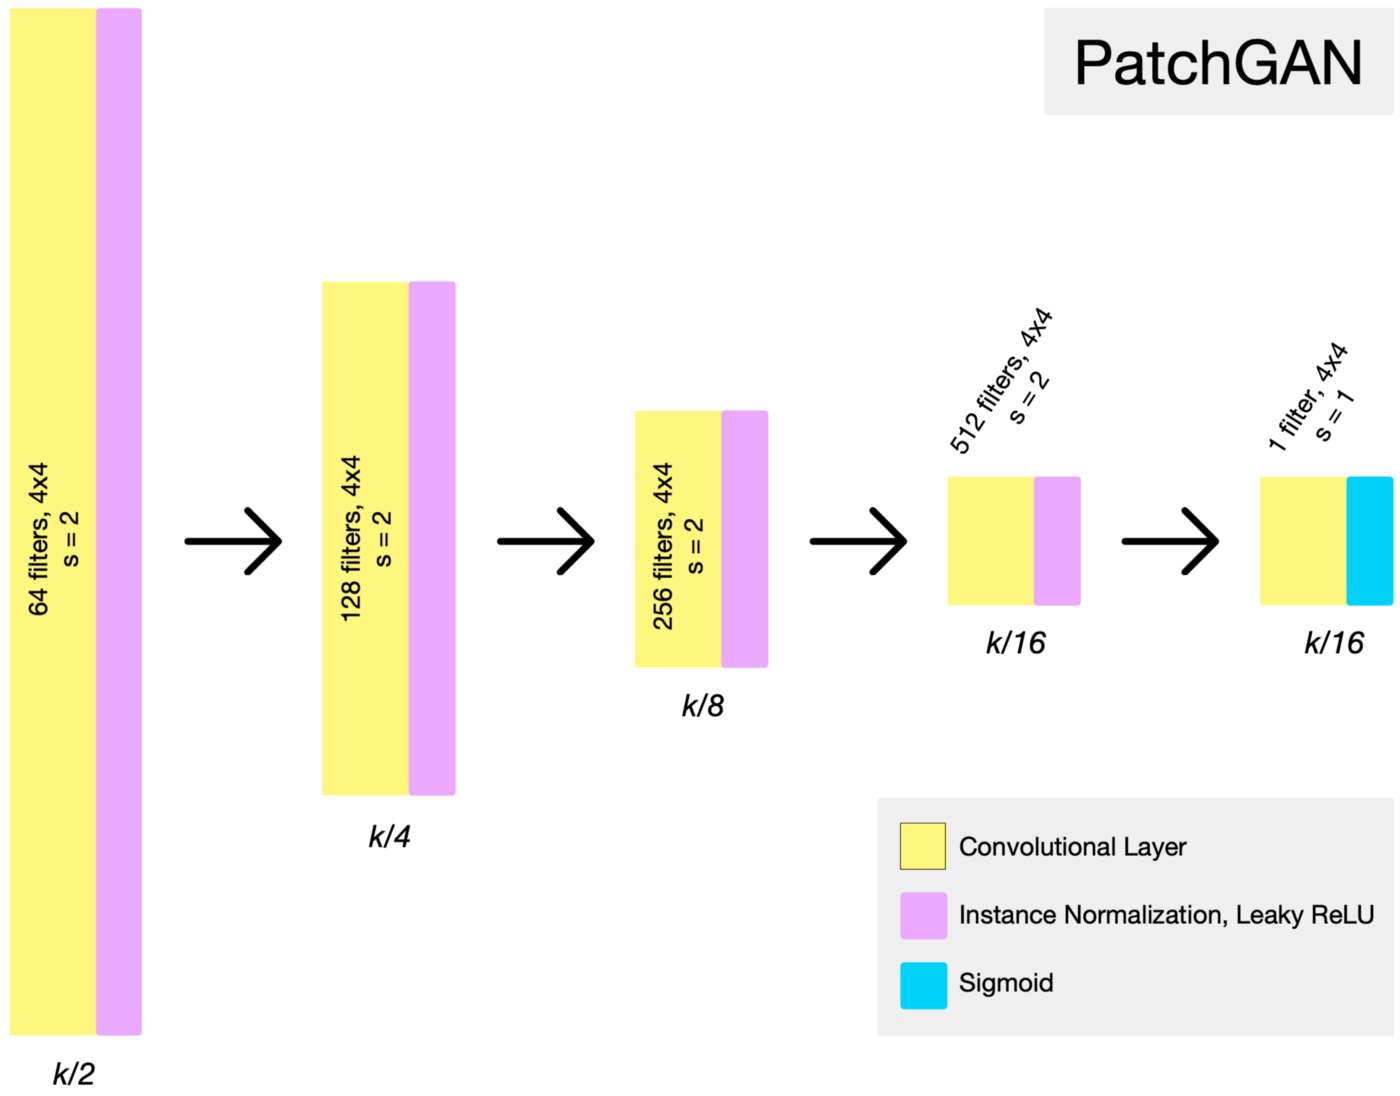

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                # 4x4 kernel size, stride and padding with reflect mode
                in_channels, out_channels, 4, stride, 1, bias=True,
                padding_mode="reflect", ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Initial convolutional block
        self.initial = nn.Sequential(
            # 4x4 kernel size with stride of 2 and padding of 1 with reflect mode
            nn.Conv2d(
                in_channels, features[0], kernel_size=4,
                stride=2, padding=1, padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        # Create block of convolutional layers with decreasing spatial dimensions
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        # Final convolutional layer with kernel size of 4, stride of 1, and padding of 1 with reflect mode
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1,
                padding=1, padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

# Important functions

In [ ]:
photos = [os.path.join("photo_jpg", path) for path in os.listdir("photo_jpg")]

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def plot_images(num_images, gen):
  for i in range(5):
    normal_path = photos[i]
    normal_img = np.array(Image.open(normal_path).convert("RGB"))

    augmentations = transforms(image=normal_img, image0=normal_img)
    normal = augmentations["image"]
    monet_img = augmentations["image0"]
    normal = normal.to(DEVICE)
    generated_sample2 = gen_monet(normal)
    photo = normal.cpu().detach() * 0.5 + 0.5
    drawing = generated_sample2.cpu().detach() * 0.5 + 0.5
    
    plt.subplot(121)
    plt.title("input image")
    plt.imshow(photo.permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(122)
    plt.title("Generated image")
    plt.imshow(drawing.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


# Final Model

### Define the Hyper parameters for the base model
In this model we use a bach of size 1 (one image per iteration). \\
the learning rate is set to 1e-5, witch is said to be the best learning rate for Cycle-Gan moedl \\
and the lamda cycly used in the cycle loss is 10 \\
the number of epochs is 20 \\
And finally in this model we added the identity loss to the model and set it to be 2

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 2.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 2
NUM_EPOCHS = 20
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose( [
        A.Resize(width=320, height=320),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(), ],
    additional_targets={"image0": "image"},
)

Define the data set.

Important now we choose the pair randomly thus the same images may be trained with diffrent moet paintings, this appraoch really heled in improving the model.

also increasing the number of pairs in each epoch

In [ ]:
class OreDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_normal = root_zebra
        self.root_monet = root_horse
        self.transform = transform

        self.normal_images = os.listdir(self.root_normal)
        self.monet_images = os.listdir(self.root_monet)
        self.length_dataset = max(len(self.normal_images), len(self.monet_images)) # 1000, 1500
        self.normal_len = len(self.normal_images)
        self.monet_len = len(self.monet_images)

    def __len__(self):
        return self.length_dataset // 6

    def __getitem__(self, index):
        rand_idx = int(np.random.uniform(0, self.normal_len))
        normal_img = self.normal_images[rand_idx]
        monet_img = self.monet_images[index % self.monet_len]

        normal_path = os.path.join(self.root_normal, normal_img)
        monet_path = os.path.join(self.root_monet, monet_img)

        normal_img = np.array(Image.open(normal_path).convert("RGB"))
        monet_img = np.array(Image.open(monet_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=normal_img, image0=monet_img)
            normal_img = augmentations["image"]
            monet_img = augmentations["image0"]

        return normal_img, monet_img

Here we defie the training function, first we train the Discriminator then the Generator

Note: Now we added the Identity loss to the model.

In [ ]:
real_monet_loss = []
fake_monet_loss = []
real_normal_loss = []
fake_normal_loss = []
monetLosses = []
monetCycleLosses = []
monetIdentityLosses = []
def train(disc_monet, disc_normal, gen_normal, gen_monet, loader,
          opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    monet_reals = 0
    monet_fakes = 0
    normal_reals = 0
    normal_fakes = 0
    loop = tqdm(loader, leave=True)
    
    monetLoss = 0
    cycleMonetLoss = 0
    identityMonetLoss = 0
    
    for idx, (normal, monet) in enumerate(loop):
        normal = normal.to(DEVICE)
        monet = monet.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_monet = gen_monet(normal)
            D_monet_real = disc_monet(monet)
            D_monet_fake = disc_monet(fake_monet.detach())
            monet_reals += D_monet_real.mean().item()
            monet_fakes += D_monet_fake.mean().item()
            D_monet_real_loss = mse(D_monet_real, torch.ones_like(D_monet_real))
            D_monet_fake_loss = mse(D_monet_fake, torch.zeros_like(D_monet_fake))
            D_monet_loss = D_monet_real_loss + D_monet_fake_loss

            fake_normal = gen_normal(monet)
            D_normal_real = disc_normal(normal)
            D_normal_fake = disc_normal(fake_normal.detach())
            normal_reals += D_normal_real.mean().item()
            normal_fakes += D_normal_fake.mean().item()
            D_normal_real_loss = mse(D_normal_real, torch.ones_like(D_normal_real))
            D_normal_fake_loss = mse(D_normal_fake, torch.zeros_like(D_normal_fake))
            D_normal_loss = D_normal_real_loss + D_normal_fake_loss

            # put it togethor
            D_loss = (D_monet_loss + D_normal_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_monet_fake = disc_monet(fake_monet)
            D_normal_fake = disc_normal(fake_normal)
            loss_G_monet = mse(D_monet_fake, torch.ones_like(D_monet_fake))
            loss_G_normal = mse(D_normal_fake, torch.ones_like(D_normal_fake))

            # cycle loss
            cycle_normal = gen_normal(fake_monet)
            cycle_monet = gen_monet(fake_normal)
            cycle_normal_loss = l1(normal, cycle_normal)
            cycle_monet_loss = l1(monet, cycle_monet)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_normal = gen_normal(normal)
            identity_monet = gen_monet(monet)
            identity_normal_loss = l1(normal, identity_normal)
            identity_monet_loss = l1(monet, identity_monet)

            # add all togethor
            G_loss = (
                loss_G_normal
                + loss_G_monet
                + cycle_normal_loss * LAMBDA_CYCLE
                + cycle_monet_loss * LAMBDA_CYCLE
                + identity_monet_loss * LAMBDA_IDENTITY
                + identity_normal_loss * LAMBDA_IDENTITY
            )
            monetLoss += loss_G_monet.item()
            cycleMonetLoss += cycle_monet_loss.item()
            identityMonetLoss += identity_monet_loss.item()

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        loop.set_postfix(monet_real=monet_reals / (idx + 1), monet_fake=monet_fakes / (idx + 1),
                        monetLoss=monetLoss/(idx+1),
                        cycleMonetLoss=cycleMonetLoss/(idx+1),
                        identityMonetLoss=identityMonetLoss/(idx+1))
    real_monet_loss.append(monet_reals / len(loader.dataset))
    fake_monet_loss.append(monet_fakes / len(loader.dataset))
    real_normal_loss.append(normal_reals / len(loader.dataset))
    fake_normal_loss.append(normal_fakes / len(loader.dataset))
    monetLosses.append(monetLoss / len(loader.dataset))
    monetCycleLosses.append(cycleMonetLoss / len(loader.dataset))
    monetIdentityLosses.append(identityMonetLoss / len(loader.dataset))

###Defining the model and Optemizers 
Here we define the 2 generators and discriminators used in the training of the Cycle-Gan model. \\
then we define the optimizers to use witch are both Adam, the reason for using Adam from the start is cause in the paper they spicify that Adam optimizers are the best for the training of the model

we also defint the loss functions L1 and MSE.

In [ ]:
#initialize generators and discriminators
gen_normal = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_monet = Generator(img_channels=3, num_residuals=9).to(DEVICE)
disc_monet = Discriminator(in_channels=3).to(DEVICE)
disc_normal = Discriminator(in_channels=3).to(DEVICE)

#initialize optimizers for the generators and discriminators
opt_disc = optim.Adam(
    list(disc_monet.parameters()) + list(disc_normal.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_gen = optim.Adam(
    list(gen_normal.parameters()) + list(gen_monet.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)
#define loss functions
L1 = nn.L1Loss()
mse = nn.MSELoss()

if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN_H, gen_monet, opt_gen, LEARNING_RATE, )
    load_checkpoint(CHECKPOINT_GEN_Z, gen_normal, opt_gen, LEARNING_RATE, )
    load_checkpoint(CHECKPOINT_CRITIC_H, disc_monet, opt_disc, LEARNING_RATE, )
    load_checkpoint(CHECKPOINT_CRITIC_Z, disc_normal, opt_disc, LEARNING_RATE, )

#create dataset and dataloader for training
dataset = OreDataset(root_horse="/kaggle/input/best-30", root_zebra="photo_jpg", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
#start training
for epoch in range(NUM_EPOCHS):
    train(disc_monet,disc_normal, gen_normal, gen_monet, loader, opt_disc, opt_gen, L1, mse,
        d_scaler, g_scaler)

    if SAVE_MODEL:
        save_checkpoint(gen_monet, opt_gen, filename=CHECKPOINT_GEN_H)
        save_checkpoint(gen_normal, opt_gen, filename=CHECKPOINT_GEN_Z)
        save_checkpoint(disc_monet, opt_disc, filename=CHECKPOINT_CRITIC_H)
        save_checkpoint(disc_normal, opt_disc, filename=CHECKPOINT_CRITIC_Z)

100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.202, identityMonetLoss=0.21, monetLoss=0.318, monet_fake=0.452, monet_real=0.556] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.145, identityMonetLoss=0.159, monetLoss=0.362, monet_fake=0.422, monet_real=0.585]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:18<00:00,  2.68it/s, cycleMonetLoss=0.125, identityMonetLoss=0.14, monetLoss=0.399, monet_fake=0.397, monet_real=0.608] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.113, identityMonetLoss=0.129, monetLoss=0.427, monet_fake=0.38, monet_real=0.622] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:18<00:00,  2.67it/s, cycleMonetLoss=0.106, identityMonetLoss=0.121, monetLoss=0.46, monet_fake=0.358, monet_real=0.641] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0994, identityMonetLoss=0.114, monetLoss=0.481, monet_fake=0.345, monet_real=0.652]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:18<00:00,  2.67it/s, cycleMonetLoss=0.0946, identityMonetLoss=0.109, monetLoss=0.509, monet_fake=0.327, monet_real=0.668]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0916, identityMonetLoss=0.105, monetLoss=0.531, monet_fake=0.314, monet_real=0.678]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0893, identityMonetLoss=0.103, monetLoss=0.543, monet_fake=0.309, monet_real=0.685]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0874, identityMonetLoss=0.0987, monetLoss=0.565, monet_fake=0.294, monet_real=0.696]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.085, identityMonetLoss=0.0977, monetLoss=0.578, monet_fake=0.287, monet_real=0.704] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:18<00:00,  2.68it/s, cycleMonetLoss=0.0839, identityMonetLoss=0.0958, monetLoss=0.599, monet_fake=0.276, monet_real=0.712]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0822, identityMonetLoss=0.0939, monetLoss=0.608, monet_fake=0.269, monet_real=0.718]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:18<00:00,  2.68it/s, cycleMonetLoss=0.0806, identityMonetLoss=0.0913, monetLoss=0.63, monet_fake=0.255, monet_real=0.73]  


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0801, identityMonetLoss=0.0895, monetLoss=0.646, monet_fake=0.245, monet_real=0.74] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0786, identityMonetLoss=0.0866, monetLoss=0.67, monet_fake=0.23, monet_real=0.752]  


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0777, identityMonetLoss=0.0849, monetLoss=0.682, monet_fake=0.222, monet_real=0.759]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.0764, identityMonetLoss=0.0831, monetLoss=0.696, monet_fake=0.214, monet_real=0.766]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:18<00:00,  2.68it/s, cycleMonetLoss=0.0799, identityMonetLoss=0.0813, monetLoss=0.715, monet_fake=0.2, monet_real=0.778]  


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1173/1173 [07:19<00:00,  2.67it/s, cycleMonetLoss=0.075, identityMonetLoss=0.0807, monetLoss=0.727, monet_fake=0.192, monet_real=0.784] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


Plots the loss of the results of the generated images

we could see the un certinety of the model at this point and how the results are unstabel

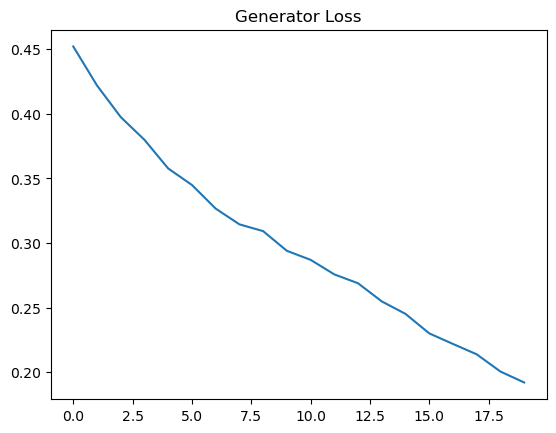

In [ ]:
plt.title("Generator Loss")
plt.plot(fake_monet_loss)
plt.show()

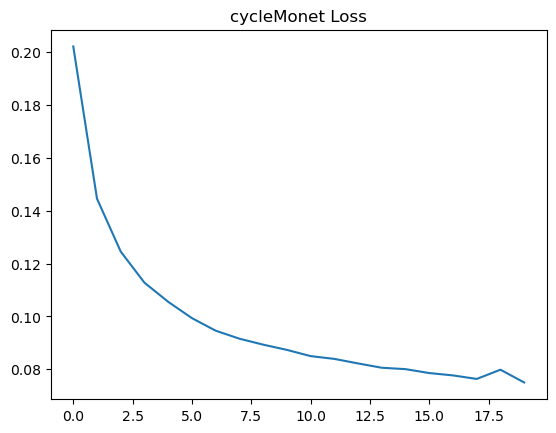

In [ ]:
plt.title("cycleMonet Loss")
plt.plot(monetCycleLosses)
plt.show()

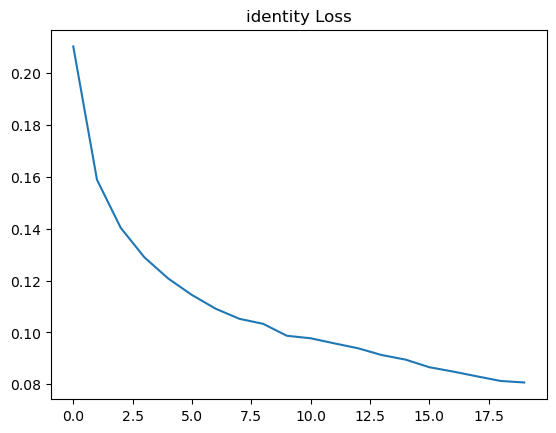

In [ ]:
plt.title("identity Loss")
plt.plot(monetIdentityLosses)
plt.show()

  0%|          | 0/1173 [00:00<?, ?it/s]

torch.Size([3, 320, 320])


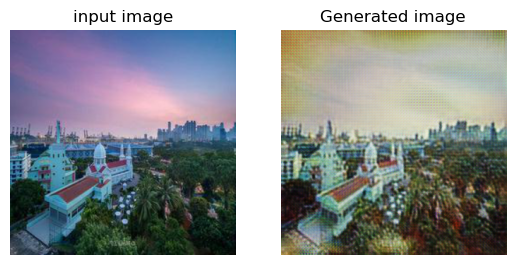

  0%|          | 1/1173 [00:00<11:02,  1.77it/s]

torch.Size([3, 320, 320])


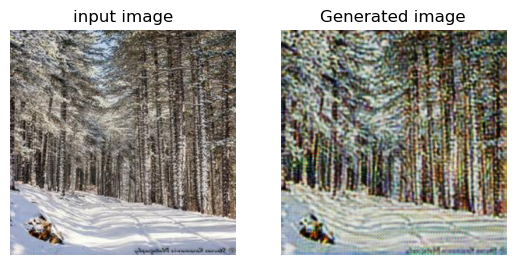

  0%|          | 2/1173 [00:00<08:14,  2.37it/s]

torch.Size([3, 320, 320])


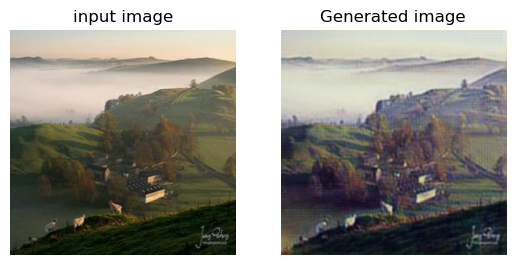

  0%|          | 3/1173 [00:01<07:22,  2.64it/s]

torch.Size([3, 320, 320])


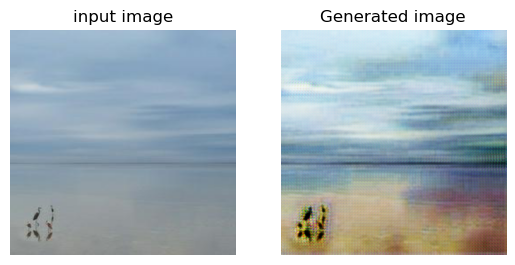

  0%|          | 4/1173 [00:01<06:52,  2.83it/s]

torch.Size([3, 320, 320])


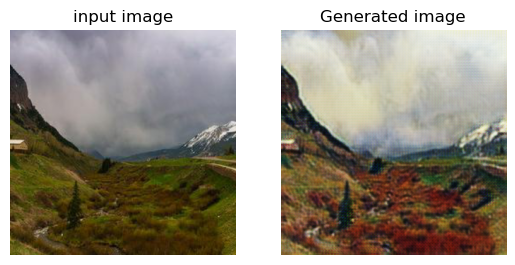

  0%|          | 5/1173 [00:01<06:37,  2.94it/s]

torch.Size([3, 320, 320])


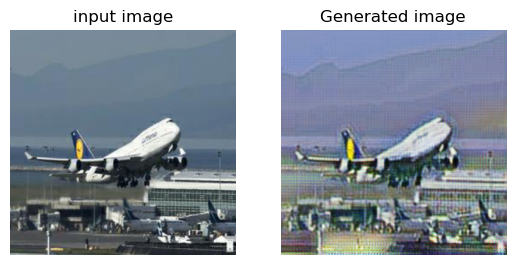

  1%|          | 6/1173 [00:02<06:17,  3.09it/s]

torch.Size([3, 320, 320])


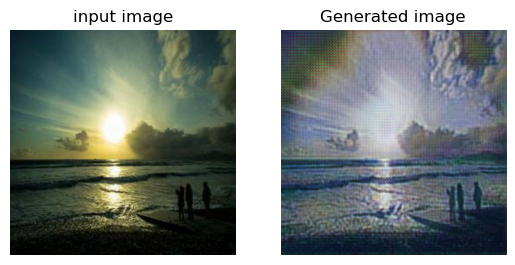

  1%|          | 7/1173 [00:02<06:14,  3.12it/s]

torch.Size([3, 320, 320])


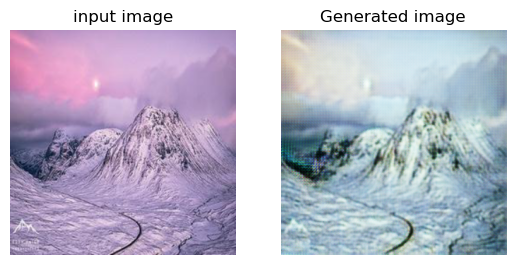

  1%|          | 8/1173 [00:02<06:13,  3.12it/s]

torch.Size([3, 320, 320])


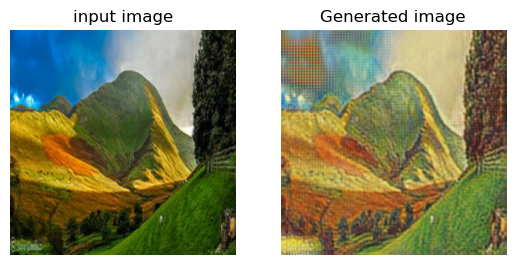

  1%|          | 9/1173 [00:03<06:08,  3.16it/s]

torch.Size([3, 320, 320])


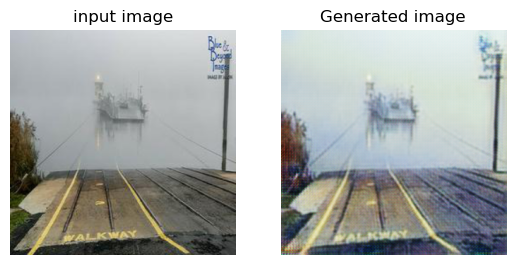

  1%|          | 10/1173 [00:03<06:04,  3.19it/s]

torch.Size([3, 320, 320])


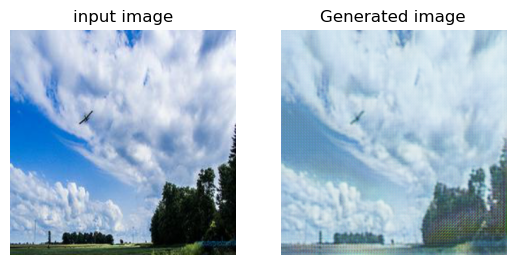

  1%|          | 11/1173 [00:03<06:09,  3.14it/s]

torch.Size([3, 320, 320])


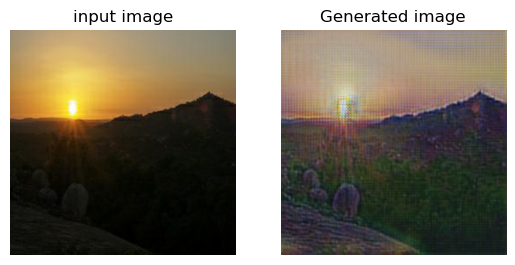

  1%|          | 12/1173 [00:04<06:08,  3.15it/s]

torch.Size([3, 320, 320])


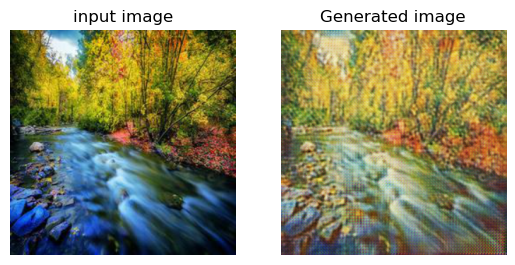

  1%|          | 13/1173 [00:04<06:02,  3.20it/s]

torch.Size([3, 320, 320])


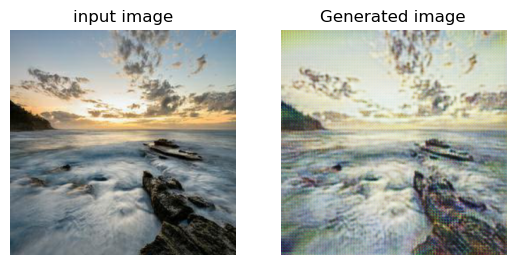

  1%|          | 14/1173 [00:04<05:59,  3.22it/s]

torch.Size([3, 320, 320])


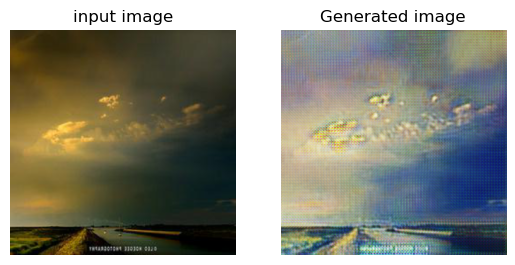

  1%|▏         | 15/1173 [00:04<05:58,  3.23it/s]

torch.Size([3, 320, 320])


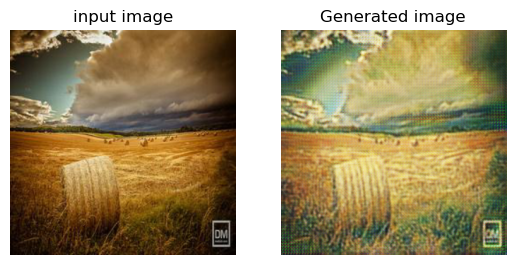

  1%|▏         | 16/1173 [00:05<06:00,  3.21it/s]

torch.Size([3, 320, 320])


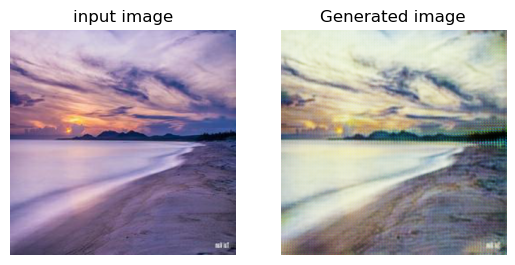

  1%|▏         | 17/1173 [00:05<06:03,  3.18it/s]

torch.Size([3, 320, 320])


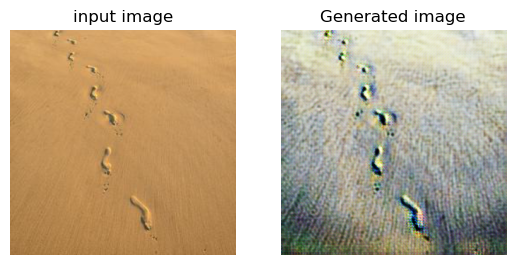

  2%|▏         | 18/1173 [00:05<06:00,  3.20it/s]

torch.Size([3, 320, 320])


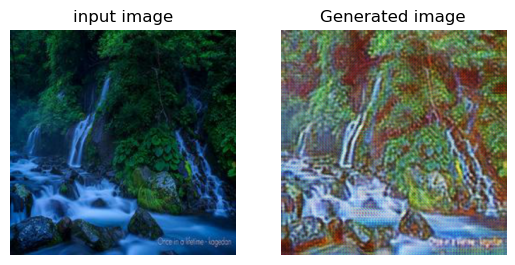

  2%|▏         | 19/1173 [00:06<06:04,  3.16it/s]

torch.Size([3, 320, 320])


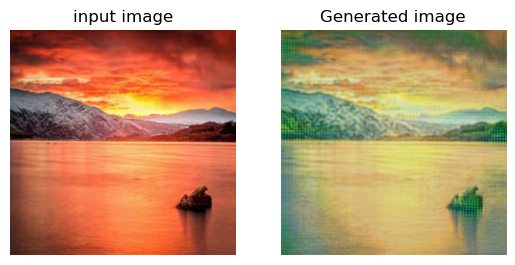

  2%|▏         | 20/1173 [00:06<08:08,  2.36it/s]

torch.Size([3, 320, 320])


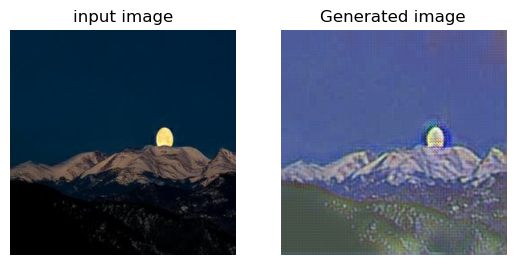

  2%|▏         | 20/1173 [00:07<06:58,  2.75it/s]


In [ ]:
i = 0
loop = tqdm(loader, leave=True)
for idx, (normal, monet) in enumerate(loop):
    normal = normal.to(DEVICE)
    monet = monet.to(DEVICE)
    generated_sample = gen_normal(monet)
    generated_sample2 = gen_monet(normal)
    photo = normal[0].cpu().detach() * 0.5 + 0.5
    drawing = generated_sample2[0].cpu().detach() * 0.5 + 0.5
    
    plt.subplot(121)
    print(photo.shape)
    plt.title("input image")
    plt.imshow(photo.permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(122)
    plt.title("Generated image")
    plt.imshow(drawing.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    if i == 20:
        break
    i += 1

# Test


To use the Cycle-Gan Model first you need to follow this steps: \\
Step 1: run theb bellow block in order to download the model. \\
Step 2: upload an image using the second code block. \\
Step 3: type the image name that was uploaded in the variable image_path in third code block then run the block to get the result. \\

Example:

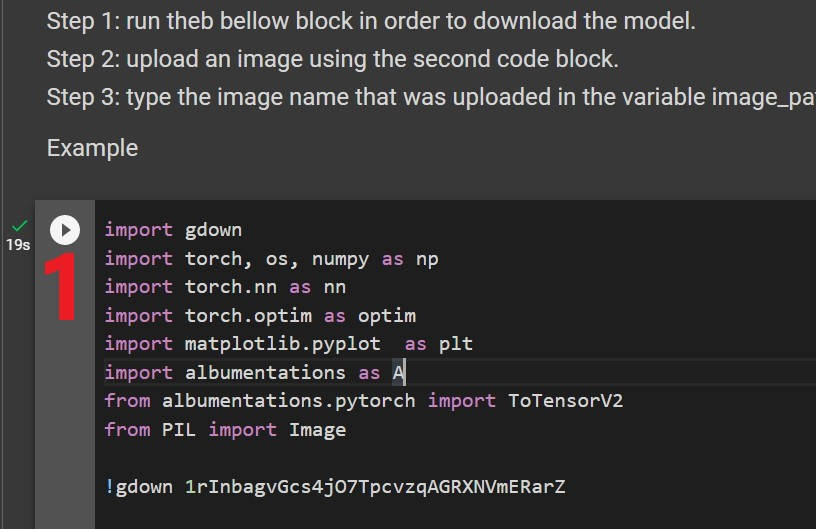

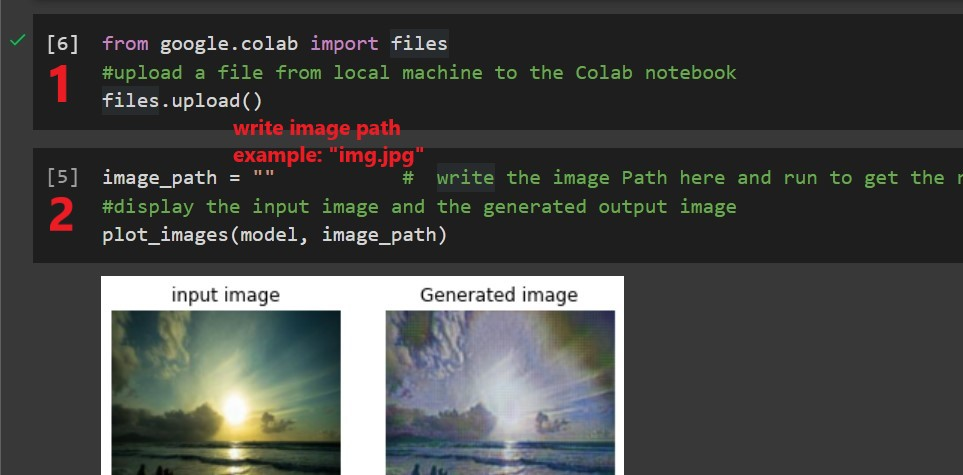

In [ ]:
import gdown
import torch, os, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot  as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

!gdown 1rInbagvGcs4jO7TpcvzqAGRXNVmERarZ

# check if cuda is available, otherwise use cpu
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def plot_images(gen, normal_path):
    normal_img = np.array(Image.open(normal_path).convert("RGB"))
    # Apply augmentations
    augmentations = transforms(image=normal_img, image0=normal_img)
    normal = augmentations["image"]
    monet_img = augmentations["image0"]
    normal = normal.to(DEVICE)

    # Generate an image using the generator
    generated_sample2 = gen(normal)
    photo = normal.cpu().detach() * 0.5 + 0.5
    drawing = generated_sample2.cpu().detach() * 0.5 + 0.5

    # Plot the input and generated images side by side
    plt.subplot(121)
    plt.title("input image")
    plt.imshow(photo.permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(122)
    plt.title("Generated image")
    plt.imshow(drawing.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
transforms = A.Compose( [
        A.Resize(width=320, height=320),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(), ],
    additional_targets={"image0": "image"},
)


#Define a convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        # define convolutional block with reflection padding, instance normalization, and ReLU activation
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

#Define a residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # define residual block with two convolutional blocks (with ReLU activation on the first block only)
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

#Define the generator network
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        # define initial convolutional block
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1,
                      padding=3, padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True), )

        self.down_blocks = nn.ModuleList([
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2,
                    padding=1
                ),
                ConvBlock(
                    num_features * 2, num_features * 4, kernel_size=3, stride=2,
                    padding=1,),
                ])
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4, num_features * 2, down=False, kernel_size=3,
                    stride=2, padding=1, output_padding=1,
                ),
                ConvBlock(
                    num_features * 2, num_features * 1, down=False, kernel_size=3,
                    stride=2, padding=1, output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1, img_channels, kernel_size=7, stride=1,
            padding=3, padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


model = torch.load("model.tar")

run the block below to upload an image

In [ ]:
from google.colab import files
#upload a file from local machine to the Colab notebook
files.upload()

Write the image path in the image_path variable bellow. \\
for example if you choose to upload img1.jpg then write: \\
image_path = "img1.jpg" \\

Run the block to get the converted image

In [ ]:
image_path = ""           #  write the image Path here and run to get the result for example image.jpg
#display the input image and the generated output image
plot_images(model, image_path)